In [12]:
import numpy as np
import glio
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import h5py as h5

In [13]:
#This function uses glio to load the particle data from the Gadget files 
#Recieves the number of the snapshot to load and the directory where the snapshots are located
#Returns the particles properties and the time of the snapshot
def load_particles( n_snapshot, input_dir):
    file_name = input_dir + f'snapshot_{n_snapshot:03}'
    print( 'Loading file: ', file_name )
    file = glio.GadgetSnapshot( file_name )
    file.load()
    head = file.header
    box_size = head.BoxSize
    current_z = head.redshift
    particle_type = 1                                   #Select dark matter particles (1) 
    positions = file.pos[particle_type]                 #Positions of dark matter particles
    mass = file.mass[particle_type]   * 1e10            #Mass of dark matter particles in Msolar
    positions_all = positions.transpose()                
    pos_z = positions_all[0]
    pos_y = positions_all[1]
    pos_x = positions_all[2]
#     velocities = file.vel[particle_type]                 #Velocities of dark matter particles
#     velocities_all = velocities.transpose()
#     vel_z = velocities_all[0]
#     vel_y = velocities_all[1]
#     vel_x = velocities_all[2]
    
    return mass, pos_x, pos_y, pos_z, current_z

In [14]:
def plot_particles( depth, pos_x, pos_y, pos_z, output_directory):
    indxs = np.where( pos_z < depth)            #Select only the particles with z<depth
    pos_x_small = pos_x[indxs]                  #positions X of selected particles
    pos_y_small = pos_y[indxs]                  #positions Y of selected particles

    fig = plt.figure(0)
    fig.clf()
    fig.set_size_inches(20,20)
    plt.tight_layout()
    axis = plt.gca()
    axis.set_xlim(0, 100000)
    axis.set_ylim(0, 100000)
    fig.axes[0].get_yaxis().set_visible(False)
    fig.axes[0].get_xaxis().set_visible(False)
    axis.scatter( pos_x_small, pos_y_small, s=0.002)   #Plot points for the particles 
    image_name = f'particles_{n_snapshot}.png'
    fig.savefig( output_directory + image_name,  pad_inches=0,  bbox_inches='tight', dpi=100 ) #Save the image
    print( "Saved image: ", output_directory + image_name )

In [15]:
def get_density( mass, pos_x, pos_y, pos_z, Lbox, nx, ny, nz ):
    dx = Lbox / nx
    dy = Lbox / ny
    dz = Lbox / nz
    dvol = dx * dy * dz
    density = np.zeros( [nx, ny, nz])

    indxs_x = ( pos_x / dx ).astype(np.int)
    indxs_y = ( pos_y / dy ).astype(np.int)
    indxs_z = ( pos_z / dz ).astype(np.int)

    total_particles = len( mass )

    for n_particle in range( total_particles ):
        indx_x = indxs_x[n_particle]
        indx_y = indxs_y[n_particle]
        indx_z = indxs_z[n_particle]
        part_mass = mass[n_particle]
        density[indx_z, indx_y, indx_x ] += part_mass

    density = density / dvol
    return density

In [17]:
def plot_density( density, Lbox, output_directory ):
       
    density_proj = density.sum( axis=0)

    image_name = output_directory + f'density_{n_snapshot:03}.png'
    fig = plt.figure(0)
    fig.clf()
    fig.set_size_inches(20,20)
    plt.tight_layout()
    fig.set_size_inches(20,20)
    axis = plt.gca()
    axis.set_xlim(0, Lbox)
    axis.set_ylim(0, Lbox)
    image = axis.imshow( np.log10(density_proj),extent=[0,Lbox, 0, Lbox], interpolation='bicubic', cmap='inferno' )
    divider = make_axes_locatable(axis)
    cax = divider.append_axes("right", size="3%", pad=0.05)
    colorbar = fig.colorbar( image, cax=cax )
    colorbar.set_label(r'Log Density  $ [\mathrm{M}_{\odot} / \mathrm{kpc}^3] $', fontsize=25)
    fig.axes[0].get_yaxis().set_visible(False)
    fig.axes[0].get_xaxis().set_visible(False)
    fig.savefig(image_name,  pad_inches=0,  bbox_inches='tight', dpi=100 ) #Save the image
    print( "Saved image: ", output_directory + image_name )


In [19]:
def plot_particles_and_density( n_slices, Lbox, density, pos_x, pos_y, output_directory  ):
    depth = n_slices * dz

    indxs = np.where( pos_z < depth)           
    pos_x_small = pos_x[indxs]                 
    pos_y_small = pos_y[indxs]
    pos_y_small = Lbox - pos_y_small 

    dens = density[0:n_slices, :, :]

    fig, axis_list = plt.subplots(nrows=1, ncols=2, figsize=(40,20),  subplot_kw={'aspect': 1})
    plt.subplots_adjust( wspace=0.01)

    axis = axis_list[0]
    image = axis.scatter( pos_x_small, pos_y_small, s=0.002) 
    axis.set_xlim(0, Lbox)
    axis.set_ylim(0, Lbox)
    axis.set_title( "Dark Matter Particles", fontsize=40)
    axis.tick_params(axis='both', which='both', bottom=False, labelbottom=False, left=False, labelleft=False)



    density_proj = dens.sum( axis=0)
    axis = axis_list[1]
    image = axis.imshow( np.log10(density_proj),extent=[0,Lbox, 0, Lbox], interpolation='bicubic', cmap='inferno' )
    axis.set_title( "Dark Matter Density", fontsize=40)
    axis.tick_params(axis='both', which='both', bottom=False, labelbottom=False, left=False, labelleft=False)
    colorbar = fig.colorbar(image, ax=axis_list, shrink=0.85, pad=0.01)
    colorbar.set_label(r'Log Density  $ [\mathrm{M}_{\odot} / \mathrm{kpc}^3] $', fontsize=25)
    image_name = f'part_dens_{n_snapshot}.png'
    fig.savefig( output_directory + image_name,  pad_inches=0.1,  bbox_inches='tight', dpi=100 ) #Save the image
    print( "Saved image: ", output_directory + image_name )  


Loading file:  data/128_dm_halos/snapshot_200
Saved image:  images/particles_density/part_dens_200.png


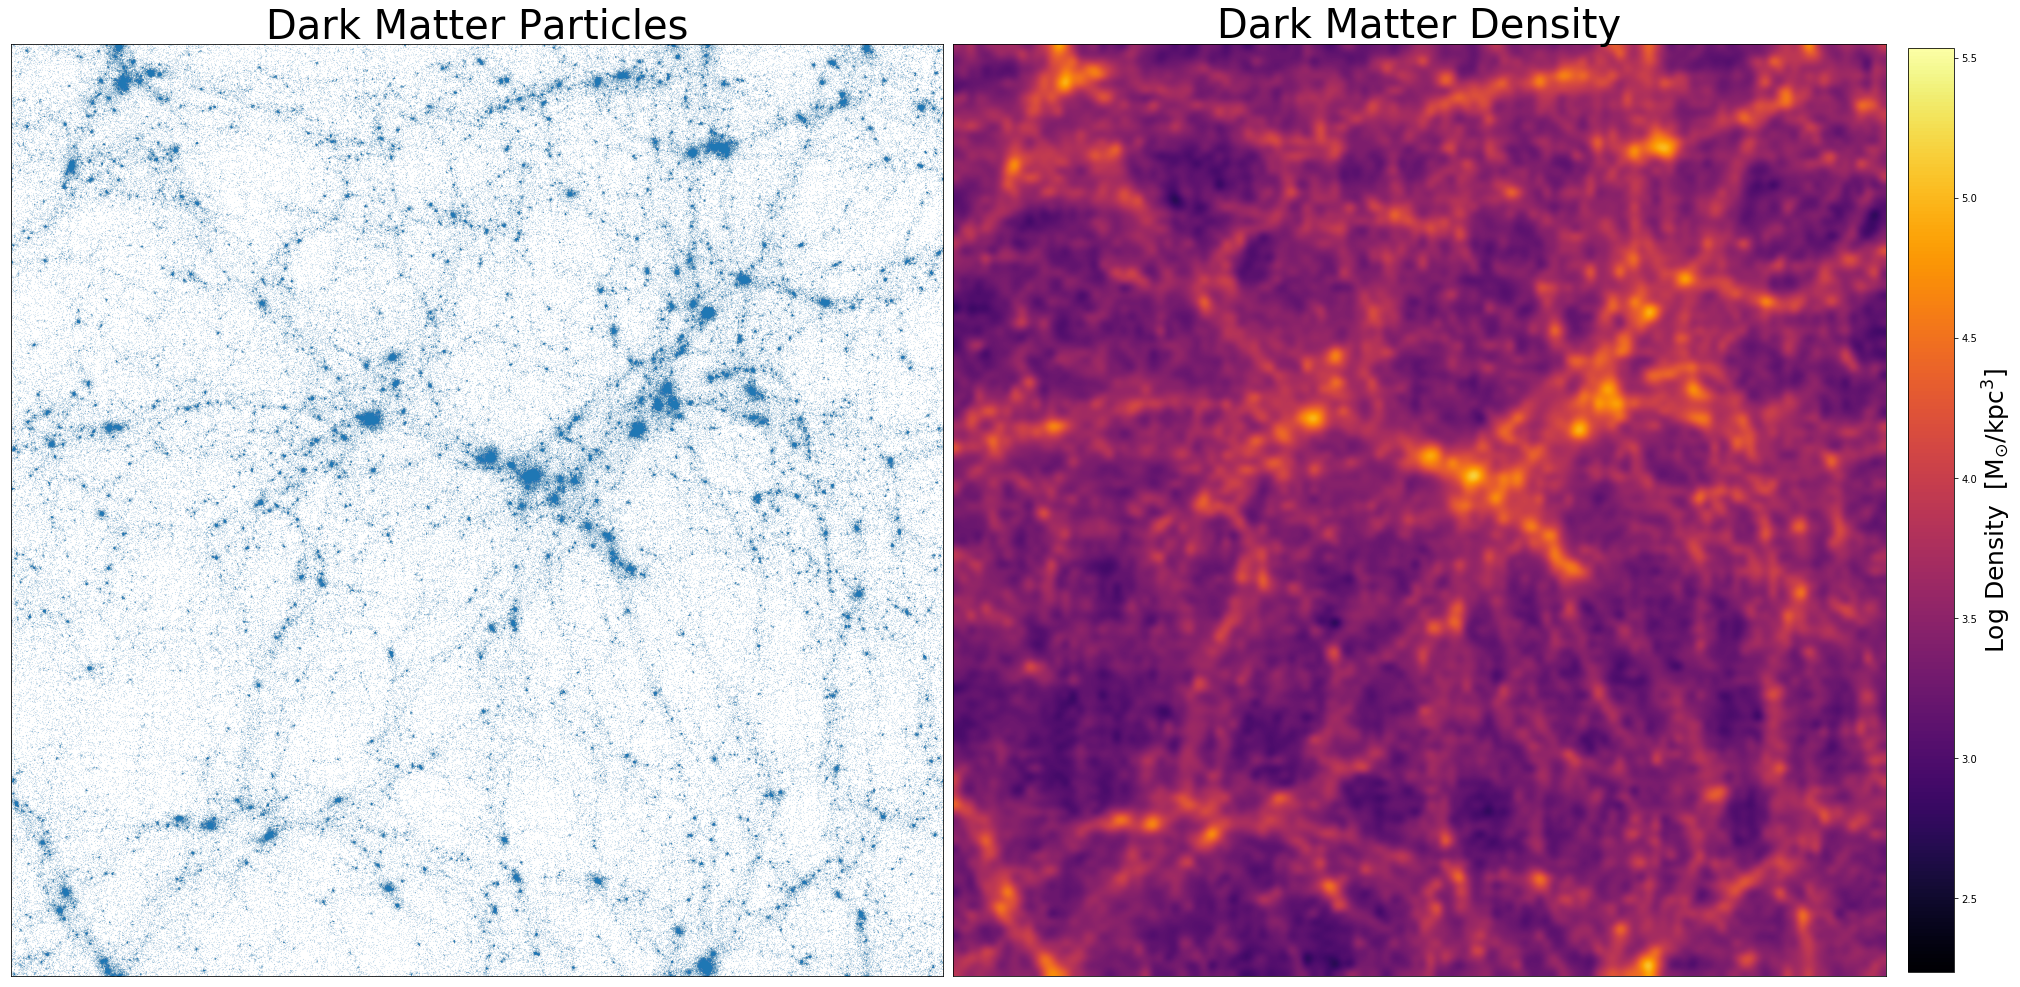

In [20]:
input_dir = 'data/128_dm_halos/'
output_directory = 'images/particles_density/'

nx = 128
ny = 128
nz = 128

Lbox = 100000 #kpc
dz = Lbox / nz

n_snapshot = 200
mass, pos_x, pos_y, pos_z, current_z = load_particles( n_snapshot, input_dir)
density = get_density( mass, pos_x, pos_y, pos_z, Lbox, nx, ny, nz )


n_slices = 64
plot_particles_and_density( n_slices, Lbox, density, pos_x, pos_y, output_directory  )



In [22]:
#Load Halo Catalogs

halo_directory = 'data/halo_catalogs_128/'

n_snapshot = 200

halo_file_name = halo_directory + f'halos_{n_snapshot:03}.ascii'
print( 'Loading halo file: ', halo_file_name)

import pandas as pd

halo_data = pd.read_csv( halo_file_name, sep=' ',  )

mass = halo_data['mvir']
mass.shape


Loading halo file:  data/halo_catalogs_128/halos_200.ascii


(7038,)

In [9]:
# input_dir = 'data/128_dm/'
# output_directory = 'images/'
# depth = 100000 

# #Loop over all the snapshots.
# #For each snapshot load the particles data and plot the positions
# for n_snapshot in range(0,201):
#     mass, pos_x, pos_y, pos_z, current_z = load_particles( n_snapshot, input_dir)
#     plot_particles( depth, pos_x, pos_y, pos_z, output_directory)


